# Walk forward univariate

Lets test walk forward validation on a univariate model

Time to train walking forward with each timestep would lead to excessive training times as there is a lot of data. Lets train a model then walk the training/validation window forward by one day until we have assesed all the data

We can plot how the metrics change over time to visualise how the data becomes easier or harder to model

## Load data and functions

In [22]:
from datetime import datetime
import pandas as pd
import numpy as np
from numpy import array
from numpy import mean
from numpy import std
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras import callbacks
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt



In [2]:
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_start_ix = end_ix + n_step_lookahead -1
        out_end_ix = end_ix + n_steps_out + n_step_lookahead -1
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[out_start_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [3]:
#To demonstrate above function
sequence = range(0,13)
n_steps_in = 1
n_steps_in = 5
n_steps_out =1
step_interval =1
n_step_lookahead=5
split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead)

(array([[0, 1, 2, 3, 4],
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 6],
        [3, 4, 5, 6, 7]]),
 array([[ 9],
        [10],
        [11],
        [12]]))

In [4]:
percentile_data = pd.read_csv (r'C:\Users/conal/Desktop/MCM/Practicum - Copy/data/block gas price percentile data.csv', header=0)
percentile_data['datetime'] = pd.to_datetime(percentile_data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')

percentile_data = percentile_data.sort_values(by='datetime',ascending=False)
percentile_data = percentile_data.set_index('datetime')
percentile_data = percentile_data.resample('5T').mean()
percentile_data = percentile_data/1000000000

In [5]:
usage_data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\ETH,gas,usage merged 11-26 to 05-26.csv', header=0)
usage_data['datetime'] = pd.to_datetime(usage_data['datetime'], format = '%Y-%m-%d %H:%M:%S')
usage_data = usage_data.set_index('datetime')

usage_data = usage_data.squeeze()
usage_data = usage_data.astype('float')
usage_data = usage_data.resample('5T').mean()

In [6]:
usage_data2 = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\Contract counts 2021-11-26 to 2022-05-26.csv', header=0, index_col=0)
usage_data2['datetime'] = pd.to_datetime(usage_data2['block_timestamp'], format = '%Y-%m-%d %H:%M:%S') 
usage_data2 = usage_data2.set_index('datetime')
usage_data2 = usage_data2.drop(['block_timestamp'], axis=1)
usage_data2 = usage_data2.squeeze()
usage_data2 = usage_data2.astype('float')
usage_data2 = usage_data2.resample('5T').sum()

In [7]:
data = usage_data.merge(percentile_data, left_index=True, right_index=True)
data = data.merge(usage_data2, left_index=True, right_index=True)

Load data, datetime to index, downsample with left edge label, convert wei to gwei

In [8]:
def generate_training_val_examples_univariate_output(data):
 
    #Filter inputs, standardize
    data =data[inputs]
    scaler = StandardScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM, filter output to only the first input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], len(inputs)))[:,:,:1]
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], len(inputs)))[:,:,:1]

    
    return X_train, y_train, X_val, y_val, scaler


In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


In [10]:
def descale_y_retrun_metrics(yhat, y_val2):
    #reverts standard scaling, returns dictionary of metrics for each output, for all lookaheads
    dict_indexes=[]
    dict_dfs=[]
    for j in range(0, n_steps_out):
        RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
        for i in range(0, len(inputs)):  
            pred_descaled= (scaler.inverse_transform(yhat[:,j:j+1,:].reshape(yhat.shape[0], yhat.shape[2])))[:, i:i+1]
            groud_truth_descaled= ((scaler.inverse_transform(y_val2[:,j:j+1,:].reshape(y_val2.shape[0], y_val2.shape[2]))))[:, i:i+1]
            RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
            MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
            MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
            MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
            R2 = r2_score(groud_truth_descaled, pred_descaled)
            RMSE_list.append(RMSE)
            MAE_list.append(MAE)
            MAPE_list.append(MAPE)
            R2_list.append(R2)
            MSE_list.append(MSE)
        metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=inputs)
        dict_dfs.append(metrics_df)
        dict_indexes.append('Lookahead' +str(j))
    metrics_dict = dict(zip(dict_indexes, dict_dfs))
    return metrics_dict

In [11]:
def descale_y_retrun_metrics_univariate_y(yhat, y_val2):
    #reverts standard scaling, returns dictionary of metrics for single output, for all lookaheads
    dict_indexes=[]
    dict_dfs=[]
    RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
    for j in range(0, n_steps_out):
        pred_descaled= scaler.inverse_transform(yhat)
        groud_truth_descaled= scaler.inverse_transform(y_val2[:,0,])
        RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
        MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
        MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
        MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
        R2 = r2_score(groud_truth_descaled, pred_descaled)
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)
        MAPE_list.append(MAPE)
        R2_list.append(R2)
        MSE_list.append(MSE)
    metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=range(1, (n_steps_out+1)))

 
    return metrics_df

In [44]:
def LSTM_model():
    checkpoint_filepath='./walk_forward/'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    model = Sequential()
    model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    return model, model_checkpoint_callback, checkpoint_filepath

## Loop for training models

In [45]:
start_date_list_py = pd.date_range(start='2021-11-26 00:00:00',end="2022-04-26 00:00:00").to_pydatetime().tolist()
end_date_list_py = pd.date_range(start='2021-12-26 23:55:00',end="2022-04-26 23:55:00").to_pydatetime().tolist()

start_dates=[]
end_dates=[]

for i in start_date_list_py:
    start_dates.append(i.strftime("%Y-%m-%d %H:%M:%S"))
    
for i in end_date_list_py:
    end_dates.append(i.strftime("%Y-%m-%d %H:%M:%S"))

In [53]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
inputs = ['min_gas_price']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1

y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in range(0, len(start_dates)):
    n_step_lookahead=1
    start_date=start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    for i in range(1,2):
        n_step_lookahead = i
     

        model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
        train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
        model.load_weights(checkpoint_filepath)
        model.save(('Walk_forward/models/day' +str(month)))

        yhat_train = model.predict(X_train, verbose=1)
        yhat_val = model.predict(X_val, verbose=1)
        y_hat_list.append(yhat_val)

        train_loss_list.append(train_history.history['loss'])
        val_loss_list.append(train_history.history['val_loss'])
        pd.DataFrame(train_loss_list).to_csv('Walk_forward/train_loss/'+str(month))
        pd.DataFrame(val_loss_list).to_csv('Walk_forward/val_loss/'+str(month))
        
        training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
        valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))

        np.save("Walk_forward/train_metric_dict_1.npy", training_metrics_dicts)  
        np.save("Walk_forward/val_metric_dict_1.npy", valdiation_metrics_dicts)  

        
        


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 59ms/step - loss: 0.3873 - val_loss: 0.0447
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2894 - val_loss: 0.0350
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2503 - val_loss: 0.0319
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2315 - val_loss: 0.0327
Epoch 5/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2196 - val_loss: 0.0291
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2121 - val_loss: 0.0294
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2077 - val_loss: 0.0305
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1993 - val_loss: 0.0302
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1972 - val_loss: 0.0295
Epoch 10/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1940 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day0\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day0\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.4892 - val_loss: 0.0566
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3418 - val_loss: 0.0483
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2788 - val_loss: 0.0448
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2406 - val_loss: 0.0383
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2300 - val_loss: 0.0330
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2133 - val_loss: 0.0335
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2046 - val_loss: 0.0310
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1986 - val_loss: 0.0311
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1994 - val_loss: 0.0309
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1901 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day1\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day1\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.2485 - val_loss: 0.0644
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2248 - val_loss: 0.0568
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2109 - val_loss: 0.0492
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1979 - val_loss: 0.0452
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1893 - val_loss: 0.0433
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1818 - val_loss: 0.0409
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1762 - val_loss: 0.0393
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1733 - val_loss: 0.0400
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1726 - val_loss: 0.0372
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1678 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day2\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day2\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 12s 57ms/step - loss: 0.2434 - val_loss: 0.0696
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2171 - val_loss: 0.0601
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2060 - val_loss: 0.0538
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1933 - val_loss: 0.0484
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1834 - val_loss: 0.0448
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1766 - val_loss: 0.0431
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1713 - val_loss: 0.0424
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1681 - val_loss: 0.0414
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1649 - val_loss: 0.0413
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1630 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day3\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day3\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 12s 58ms/step - loss: 0.2343 - val_loss: 0.0710
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2201 - val_loss: 0.0612
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2086 - val_loss: 0.0548
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1965 - val_loss: 0.0489
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1833 - val_loss: 0.0458
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1748 - val_loss: 0.0445
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1675 - val_loss: 0.0448
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1651 - val_loss: 0.0440
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1649 - val_loss: 0.0467
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1601 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day4\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day4\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 61ms/step - loss: 0.2646 - val_loss: 0.0741
Epoch 2/15
152/152 [==============================] - 8s 51ms/step - loss: 0.2233 - val_loss: 0.0630
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2100 - val_loss: 0.0556
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1974 - val_loss: 0.0499
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1844 - val_loss: 0.0440
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1768 - val_loss: 0.0420
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1717 - val_loss: 0.0402
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1743 - val_loss: 0.0396
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1663 - val_loss: 0.0397
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1636 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day5\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day5\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.2556 - val_loss: 0.0856
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2207 - val_loss: 0.0673
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2069 - val_loss: 0.0563
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1896 - val_loss: 0.0501
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1781 - val_loss: 0.0464
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1715 - val_loss: 0.0445
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1664 - val_loss: 0.0433
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1671 - val_loss: 0.0428
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1619 - val_loss: 0.0436
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1611 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day6\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day6\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.2282 - val_loss: 0.1118
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2108 - val_loss: 0.0968
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2016 - val_loss: 0.0830
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1876 - val_loss: 0.0676
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1764 - val_loss: 0.0627
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1686 - val_loss: 0.0609
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1650 - val_loss: 0.0597
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1656 - val_loss: 0.0596
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1607 - val_loss: 0.0596
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1600 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day7\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day7\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.1631 - val_loss: 0.1312
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1443 - val_loss: 0.1144
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1374 - val_loss: 0.1030
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1325 - val_loss: 0.0931
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1278 - val_loss: 0.0871
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1232 - val_loss: 0.0793
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1196 - val_loss: 0.0739
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1161 - val_loss: 0.0693
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1154 - val_loss: 0.0680
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1126 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day8\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day8\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 55ms/step - loss: 0.1561 - val_loss: 0.1534
Epoch 2/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1412 - val_loss: 0.1341
Epoch 3/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1337 - val_loss: 0.1158
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1266 - val_loss: 0.1065
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1213 - val_loss: 0.1005
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1189 - val_loss: 0.0972
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1178 - val_loss: 0.0930
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1162 - val_loss: 0.0928
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1177 - val_loss: 0.0909
Epoch 10/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1143 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day9\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day9\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 61ms/step - loss: 0.1730 - val_loss: 0.2005
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1455 - val_loss: 0.1760
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1373 - val_loss: 0.1578
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1311 - val_loss: 0.1434
Epoch 5/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1270 - val_loss: 0.1435
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1229 - val_loss: 0.1290
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1203 - val_loss: 0.1206
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1185 - val_loss: 0.1183
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1168 - val_loss: 0.1161
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1151 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day10\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day10\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.1939 - val_loss: 0.2265
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1458 - val_loss: 0.1990
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1373 - val_loss: 0.1791
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1301 - val_loss: 0.1630
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1251 - val_loss: 0.1503
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1199 - val_loss: 0.1425
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1156 - val_loss: 0.1308
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1141 - val_loss: 0.1311
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1131 - val_loss: 0.1259
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1113 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day11\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day11\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.1777 - val_loss: 0.2496
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1391 - val_loss: 0.2122
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1328 - val_loss: 0.1903
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1253 - val_loss: 0.1710
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1198 - val_loss: 0.1527
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1165 - val_loss: 0.1441
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1135 - val_loss: 0.1429
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1117 - val_loss: 0.1380
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1114 - val_loss: 0.1402
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1105 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day12\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day12\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.1851 - val_loss: 0.2604
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1465 - val_loss: 0.2220
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1374 - val_loss: 0.2070
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1306 - val_loss: 0.1914
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1251 - val_loss: 0.1778
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1199 - val_loss: 0.1585
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1163 - val_loss: 0.1529
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1133 - val_loss: 0.1450
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1118 - val_loss: 0.1469
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1121 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day13\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day13\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 55ms/step - loss: 0.1660 - val_loss: 0.3148
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1394 - val_loss: 0.2994
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1342 - val_loss: 0.2657
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1295 - val_loss: 0.2561
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1239 - val_loss: 0.2306
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1183 - val_loss: 0.2155
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1146 - val_loss: 0.1947
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1127 - val_loss: 0.1984
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1112 - val_loss: 0.1918
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1091 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day14\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day14\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.1174 - val_loss: 0.4123
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0925 - val_loss: 0.3422
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0827 - val_loss: 0.2891
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0751 - val_loss: 0.2565
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0702 - val_loss: 0.2347
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0678 - val_loss: 0.2155
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0654 - val_loss: 0.2280
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0641 - val_loss: 0.2206
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0644 - val_loss: 0.2177
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0642 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day15\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day15\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.1380 - val_loss: 0.4217
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1104 - val_loss: 0.3204
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0962 - val_loss: 0.2711
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0871 - val_loss: 0.2546
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0804 - val_loss: 0.2345
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0776 - val_loss: 0.2590
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0755 - val_loss: 0.2268
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0744 - val_loss: 0.2158
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0743 - val_loss: 0.2105
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0743 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day16\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day16\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.1651 - val_loss: 0.6848
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1115 - val_loss: 0.5204
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0953 - val_loss: 0.4481
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0874 - val_loss: 0.4285
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0783 - val_loss: 0.4009
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0716 - val_loss: 0.3787
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0692 - val_loss: 0.3730
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0677 - val_loss: 0.3647
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0680 - val_loss: 0.3600
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0666 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day17\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day17\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.1902 - val_loss: 0.5903
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1225 - val_loss: 0.4792
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1039 - val_loss: 0.4273
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0916 - val_loss: 0.3940
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0845 - val_loss: 0.3694
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0785 - val_loss: 0.3726
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0770 - val_loss: 0.3602
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0748 - val_loss: 0.3488
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0832 - val_loss: 0.3480
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0730 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day18\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day18\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 55ms/step - loss: 0.1645 - val_loss: 0.6358
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1212 - val_loss: 0.5329
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1044 - val_loss: 0.4576
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0934 - val_loss: 0.4550
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0907 - val_loss: 0.4336
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0856 - val_loss: 0.4215
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0895 - val_loss: 0.4125
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0824 - val_loss: 0.4091
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0855 - val_loss: 0.4009
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0809 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day19\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day19\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 55ms/step - loss: 0.2523 - val_loss: 0.7367
Epoch 2/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1409 - val_loss: 0.5969
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1192 - val_loss: 0.5319
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1049 - val_loss: 0.4571
Epoch 5/15
152/152 [==============================] - 8s 51ms/step - loss: 0.0945 - val_loss: 0.4376
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 0.0886 - val_loss: 0.4159
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 0.0869 - val_loss: 0.4181
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 0.0880 - val_loss: 0.4087
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0834 - val_loss: 0.4038
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0830 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day20\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day20\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 55ms/step - loss: 0.3177 - val_loss: 0.7166
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1707 - val_loss: 0.5540
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1441 - val_loss: 0.4895
Epoch 4/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1252 - val_loss: 0.4505
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1134 - val_loss: 0.4224
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1080 - val_loss: 0.4084
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1034 - val_loss: 0.3983
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1055 - val_loss: 0.3877
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1001 - val_loss: 0.3896
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1043 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day21\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day21\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 55ms/step - loss: 0.3472 - val_loss: 0.5186
Epoch 2/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1817 - val_loss: 0.4719
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1557 - val_loss: 0.4396
Epoch 4/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1395 - val_loss: 0.4159
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1273 - val_loss: 0.4037
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1224 - val_loss: 0.3958
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1181 - val_loss: 0.3974
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1191 - val_loss: 0.3858
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1147 - val_loss: 0.3868
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1150 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day22\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day22\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 55ms/step - loss: 0.4572 - val_loss: 0.5349
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2244 - val_loss: 0.4768
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1928 - val_loss: 0.4335
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1701 - val_loss: 0.4106
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1569 - val_loss: 0.3907
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1456 - val_loss: 0.3780
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1388 - val_loss: 0.3701
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1415 - val_loss: 0.3628
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1359 - val_loss: 0.3604
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1405 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day23\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day23\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 56ms/step - loss: 0.3495 - val_loss: 0.4162
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2213 - val_loss: 0.3779
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2024 - val_loss: 0.3590
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1922 - val_loss: 0.3466
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1855 - val_loss: 0.3344
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1799 - val_loss: 0.3265
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1715 - val_loss: 0.3306
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1659 - val_loss: 0.3173
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1684 - val_loss: 0.3151
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1599 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day24\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day24\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 55ms/step - loss: 0.5227 - val_loss: 0.4209
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3007 - val_loss: 0.3656
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2663 - val_loss: 0.3273
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2431 - val_loss: 0.2995
Epoch 5/15
152/152 [==============================] - 8s 51ms/step - loss: 0.2285 - val_loss: 0.2841
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 0.2195 - val_loss: 0.2738
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 0.2142 - val_loss: 0.2692
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2132 - val_loss: 0.2648
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2080 - val_loss: 0.2625
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2053 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day25\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day25\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 13s 75ms/step - loss: 0.5977 - val_loss: 0.3528
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3436 - val_loss: 0.3071
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3078 - val_loss: 0.2833
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2843 - val_loss: 0.2635
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2720 - val_loss: 0.2537
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2607 - val_loss: 0.2402
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2509 - val_loss: 0.2348
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2493 - val_loss: 0.2321
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 0.2414 - val_loss: 0.2278
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2435 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day26\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day26\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.5208 - val_loss: 0.3364
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3115 - val_loss: 0.2924
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2775 - val_loss: 0.2616
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2576 - val_loss: 0.2515
Epoch 5/15
152/152 [==============================] - 8s 51ms/step - loss: 0.2468 - val_loss: 0.2345
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2389 - val_loss: 0.2272
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 0.2362 - val_loss: 0.2259
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 0.2292 - val_loss: 0.2235
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 0.2297 - val_loss: 0.2243
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 0.2321 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day27\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day27\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.4750 - val_loss: 0.3898
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3374 - val_loss: 0.3344
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3007 - val_loss: 0.2975
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2731 - val_loss: 0.2778
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2600 - val_loss: 0.2617
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2480 - val_loss: 0.2532
Epoch 7/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2394 - val_loss: 0.2476
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2373 - val_loss: 0.2446
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2334 - val_loss: 0.2427
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2362 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day28\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day28\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 56ms/step - loss: 0.4863 - val_loss: 0.3382
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3336 - val_loss: 0.2747
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2987 - val_loss: 0.2414
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2814 - val_loss: 0.2299
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2819 - val_loss: 0.2203
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2613 - val_loss: 0.2158
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2649 - val_loss: 0.2104
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2585 - val_loss: 0.2093
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2538 - val_loss: 0.2045
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2677 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day29\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day29\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.5008 - val_loss: 0.3783
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3403 - val_loss: 0.3104
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3067 - val_loss: 0.2825
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2842 - val_loss: 0.2626
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2707 - val_loss: 0.2503
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2768 - val_loss: 0.2446
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2640 - val_loss: 0.2399
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2598 - val_loss: 0.2367
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2559 - val_loss: 0.2380
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2592 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day30\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day30\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.6720 - val_loss: 0.4326
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3684 - val_loss: 0.3614
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3276 - val_loss: 0.3177
Epoch 4/15
152/152 [==============================] - 9s 60ms/step - loss: 0.3077 - val_loss: 0.2956
Epoch 5/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2926 - val_loss: 0.2799
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2803 - val_loss: 0.2673
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2725 - val_loss: 0.2571
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2729 - val_loss: 0.2509
Epoch 9/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2633 - val_loss: 0.2466
Epoch 10/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2588 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day31\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day31\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.8200 - val_loss: 0.3658
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.4279 - val_loss: 0.2852
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3651 - val_loss: 0.2501
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3341 - val_loss: 0.2321
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3155 - val_loss: 0.2209
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3047 - val_loss: 0.2135
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2981 - val_loss: 0.2071
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2893 - val_loss: 0.2040
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2852 - val_loss: 0.2016
Epoch 10/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2818 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day32\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day32\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.6924 - val_loss: 0.3070
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.4015 - val_loss: 0.2423
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3570 - val_loss: 0.2138
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3321 - val_loss: 0.1976
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3157 - val_loss: 0.1915
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3084 - val_loss: 0.1811
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2983 - val_loss: 0.1849
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2891 - val_loss: 0.1744
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2855 - val_loss: 0.1714
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2824 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day33\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day33\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.7614 - val_loss: 0.2211
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.4157 - val_loss: 0.1896
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3664 - val_loss: 0.1757
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3347 - val_loss: 0.1641
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3135 - val_loss: 0.1750
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3061 - val_loss: 0.1550
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3022 - val_loss: 0.1569
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2911 - val_loss: 0.1527
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2861 - val_loss: 0.1498
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2869 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day34\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day34\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 12s 56ms/step - loss: 0.6664 - val_loss: 0.4166
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.4025 - val_loss: 0.3937
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3660 - val_loss: 0.3738
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3405 - val_loss: 0.3612
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3238 - val_loss: 0.3464
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3132 - val_loss: 0.3363
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3063 - val_loss: 0.3264
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2969 - val_loss: 0.3220
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2891 - val_loss: 0.3136
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2851 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day35\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day35\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.7032 - val_loss: 0.4105
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3956 - val_loss: 0.3743
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3512 - val_loss: 0.3580
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3361 - val_loss: 0.3354
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3172 - val_loss: 0.3226
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3036 - val_loss: 0.3139
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2933 - val_loss: 0.3025
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3009 - val_loss: 0.3029
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2887 - val_loss: 0.2929
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2867 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day36\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day36\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.7175 - val_loss: 0.4347
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.4292 - val_loss: 0.3725
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3625 - val_loss: 0.3391
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3350 - val_loss: 0.3148
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3188 - val_loss: 0.3014
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3088 - val_loss: 0.2964
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3043 - val_loss: 0.2890
Epoch 8/15
152/152 [==============================] - 9s 57ms/step - loss: 0.3072 - val_loss: 0.2861
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2985 - val_loss: 0.2811
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3014 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day37\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day37\assets


65/65 [==============================] - 1s 22ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 12s 63ms/step - loss: 0.6221 - val_loss: 0.5303
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3902 - val_loss: 0.4749
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3477 - val_loss: 0.4362
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3242 - val_loss: 0.4105
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3103 - val_loss: 0.3965
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2992 - val_loss: 0.3769
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2994 - val_loss: 0.3743
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2949 - val_loss: 0.3596
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2883 - val_loss: 0.3561
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2861 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day38\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day38\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 58ms/step - loss: 0.5552 - val_loss: 0.5355
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3613 - val_loss: 0.4785
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3245 - val_loss: 0.4421
Epoch 4/15
152/152 [==============================] - 8s 55ms/step - loss: 0.3047 - val_loss: 0.4211
Epoch 5/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2931 - val_loss: 0.4039
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2864 - val_loss: 0.3919
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2830 - val_loss: 0.3835
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2780 - val_loss: 0.3769
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2870 - val_loss: 0.3740
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2853 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day39\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day39\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.5462 - val_loss: 0.5331
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3685 - val_loss: 0.4815
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3290 - val_loss: 0.4508
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3073 - val_loss: 0.4282
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2930 - val_loss: 0.4071
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2821 - val_loss: 0.3924
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2789 - val_loss: 0.3824
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2742 - val_loss: 0.3763
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2762 - val_loss: 0.3712
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2695 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day40\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day40\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 58ms/step - loss: 0.6124 - val_loss: 3.1731
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3214 - val_loss: 3.1234
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2806 - val_loss: 3.0874
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2502 - val_loss: 3.0587
Epoch 5/15
152/152 [==============================] - 9s 56ms/step - loss: 0.2369 - val_loss: 3.0451
Epoch 6/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2259 - val_loss: 3.0253
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2251 - val_loss: 3.0138
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2117 - val_loss: 3.0045
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2060 - val_loss: 3.0006
Epoch 10/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2043 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day41\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day41\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 58ms/step - loss: 0.3191 - val_loss: 3.0853
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2594 - val_loss: 3.0517
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2318 - val_loss: 3.0266
Epoch 4/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2175 - val_loss: 3.0100
Epoch 5/15
152/152 [==============================] - 9s 56ms/step - loss: 0.2139 - val_loss: 2.9992
Epoch 6/15
152/152 [==============================] - 9s 56ms/step - loss: 0.2114 - val_loss: 2.9945
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2050 - val_loss: 2.9884
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2071 - val_loss: 2.9850
Epoch 9/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2012 - val_loss: 2.9853
Epoch 10/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1991 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day42\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day42\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.4043 - val_loss: 2.9076
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3173 - val_loss: 2.8786
Epoch 3/15
152/152 [==============================] - 8s 56ms/step - loss: 0.2946 - val_loss: 2.8574
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2785 - val_loss: 2.8416
Epoch 5/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2655 - val_loss: 2.8315
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2596 - val_loss: 2.8255
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2503 - val_loss: 2.8206
Epoch 8/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2526 - val_loss: 2.8211
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 0.2441 - val_loss: 2.8208
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2502 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day43\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day43\assets


65/65 [==============================] - 1s 21ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 59ms/step - loss: 0.6770 - val_loss: 2.9282
Epoch 2/15
152/152 [==============================] - 9s 57ms/step - loss: 0.3741 - val_loss: 2.8858
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3341 - val_loss: 2.8598
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3048 - val_loss: 2.8421
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2846 - val_loss: 2.8344
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2733 - val_loss: 2.8241
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2702 - val_loss: 2.8228
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2624 - val_loss: 2.8207
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2576 - val_loss: 2.8288
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2578 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day44\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day44\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.9333 - val_loss: 2.8395
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.4573 - val_loss: 2.8050
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3917 - val_loss: 2.7845
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3579 - val_loss: 2.7728
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3348 - val_loss: 2.7626
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3138 - val_loss: 2.7545
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2989 - val_loss: 2.7497
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2886 - val_loss: 2.7489
Epoch 9/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2828 - val_loss: 2.7436
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2813 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day45\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day45\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.5969 - val_loss: 2.9018
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3904 - val_loss: 2.8829
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3368 - val_loss: 2.8754
Epoch 4/15
152/152 [==============================] - 8s 55ms/step - loss: 0.3143 - val_loss: 2.8679
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2920 - val_loss: 2.8627
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2813 - val_loss: 2.8586
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2800 - val_loss: 2.8589
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2707 - val_loss: 2.8577
Epoch 9/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2717 - val_loss: 2.8592
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2735 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day46\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day46\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 61ms/step - loss: 0.5052 - val_loss: 2.8652
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3663 - val_loss: 2.8553
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3353 - val_loss: 2.8460
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3169 - val_loss: 2.8452
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 0.3034 - val_loss: 2.8386
Epoch 6/15
152/152 [==============================] - 8s 56ms/step - loss: 0.2941 - val_loss: 2.8363
Epoch 7/15
152/152 [==============================] - 8s 55ms/step - loss: 0.2960 - val_loss: 2.8349
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2902 - val_loss: 2.8357
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2810 - val_loss: 2.8350
Epoch 10/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2850 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day47\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day47\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 1.5794 - val_loss: 0.2399
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4646 - val_loss: 0.2342
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4366 - val_loss: 0.2367
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4161 - val_loss: 0.2368
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4035 - val_loss: 0.2347
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4024 - val_loss: 0.2360
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3940 - val_loss: 0.2375
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3982 - val_loss: 0.2204
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3930 - val_loss: 0.2208
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3899 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day48\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day48\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 1.5947 - val_loss: 0.2655
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4503 - val_loss: 0.2434
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4209 - val_loss: 0.2303
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4150 - val_loss: 0.2255
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3925 - val_loss: 0.2183
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3845 - val_loss: 0.2178
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3762 - val_loss: 0.2166
Epoch 8/15
152/152 [==============================] - 8s 55ms/step - loss: 1.3696 - val_loss: 0.2116
Epoch 9/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3691 - val_loss: 0.2326
Epoch 10/15
152/152 [==============================] - 8s 55ms/step - loss: 1.3673 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day49\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day49\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 58ms/step - loss: 1.6932 - val_loss: 0.3187
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4832 - val_loss: 0.2818
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4495 - val_loss: 0.2555
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4296 - val_loss: 0.2428
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4155 - val_loss: 0.2330
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4042 - val_loss: 0.2282
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3918 - val_loss: 0.2220
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3826 - val_loss: 0.2213
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3757 - val_loss: 0.2176
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3683 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day50\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day50\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 55ms/step - loss: 1.5418 - val_loss: 0.2595
Epoch 2/15
152/152 [==============================] - 8s 51ms/step - loss: 1.4306 - val_loss: 0.2431
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4103 - val_loss: 0.2418
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3943 - val_loss: 0.2267
Epoch 5/15
152/152 [==============================] - 8s 55ms/step - loss: 1.3771 - val_loss: 0.2266
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3684 - val_loss: 0.2238
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3604 - val_loss: 0.2199
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3551 - val_loss: 0.2237
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3588 - val_loss: 0.2241
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3528 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day51\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day51\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 1.5378 - val_loss: 0.2798
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4458 - val_loss: 0.2624
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4174 - val_loss: 0.2532
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4006 - val_loss: 0.2454
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3839 - val_loss: 0.2345
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3762 - val_loss: 0.2341
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3642 - val_loss: 0.2313
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3573 - val_loss: 0.2241
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3499 - val_loss: 0.2301
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3524 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day52\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day52\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 12s 57ms/step - loss: 1.5966 - val_loss: 0.1093
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4799 - val_loss: 0.1003
Epoch 3/15
152/152 [==============================] - 9s 57ms/step - loss: 1.4545 - val_loss: 0.0918
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4399 - val_loss: 0.0879
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4306 - val_loss: 0.0853
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4203 - val_loss: 0.0791
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4175 - val_loss: 0.0810
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4115 - val_loss: 0.0785
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4080 - val_loss: 0.0774
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4094 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day53\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day53\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 58ms/step - loss: 1.6375 - val_loss: 0.1216
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4817 - val_loss: 0.1034
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4517 - val_loss: 0.0962
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4324 - val_loss: 0.0921
Epoch 5/15
152/152 [==============================] - 8s 55ms/step - loss: 1.4194 - val_loss: 0.0819
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4253 - val_loss: 0.0767
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4081 - val_loss: 0.1118
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4057 - val_loss: 0.0747
Epoch 9/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3972 - val_loss: 0.0772
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3944 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day54\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day54\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 1.5927 - val_loss: 0.1025
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4766 - val_loss: 0.0916
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4472 - val_loss: 0.0816
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4292 - val_loss: 0.0825
Epoch 5/15
152/152 [==============================] - 8s 55ms/step - loss: 1.4191 - val_loss: 0.0711
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4098 - val_loss: 0.0699
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4051 - val_loss: 0.0680
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4123 - val_loss: 0.0703
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4085 - val_loss: 0.0687
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3947 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day55\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day55\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 58ms/step - loss: 1.5309 - val_loss: 0.1797
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4578 - val_loss: 0.1695
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4391 - val_loss: 0.1546
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4242 - val_loss: 0.1546
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4172 - val_loss: 0.1439
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4084 - val_loss: 0.1466
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4080 - val_loss: 0.1382
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3973 - val_loss: 0.1445
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3903 - val_loss: 0.1354
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3865 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day56\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day56\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 1.5191 - val_loss: 0.1709
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4584 - val_loss: 0.1620
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4342 - val_loss: 0.1493
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4181 - val_loss: 0.1457
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4009 - val_loss: 0.1448
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3896 - val_loss: 0.1484
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3851 - val_loss: 0.1347
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3812 - val_loss: 0.1334
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3814 - val_loss: 0.1358
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3756 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day57\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day57\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 1.5614 - val_loss: 0.1605
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4796 - val_loss: 0.1497
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4527 - val_loss: 0.1484
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4352 - val_loss: 0.1396
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4220 - val_loss: 0.1355
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4115 - val_loss: 0.1318
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4013 - val_loss: 0.1249
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3942 - val_loss: 0.1244
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3888 - val_loss: 0.1216
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3839 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day58\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day58\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 61ms/step - loss: 1.4737 - val_loss: 0.2306
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3810 - val_loss: 0.2145
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3586 - val_loss: 0.2050
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3465 - val_loss: 0.1958
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3345 - val_loss: 0.1865
Epoch 6/15
152/152 [==============================] - 8s 55ms/step - loss: 1.3235 - val_loss: 0.1788
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3244 - val_loss: 0.1787
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3153 - val_loss: 0.1914
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3160 - val_loss: 0.1754
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3104 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day59\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day59\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 1.4432 - val_loss: 0.2266
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3656 - val_loss: 0.2001
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3450 - val_loss: 0.1857
Epoch 4/15
152/152 [==============================] - 8s 55ms/step - loss: 1.3327 - val_loss: 0.1799
Epoch 5/15
152/152 [==============================] - 8s 56ms/step - loss: 1.3269 - val_loss: 0.1751
Epoch 6/15
152/152 [==============================] - 8s 55ms/step - loss: 1.3220 - val_loss: 0.1691
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3149 - val_loss: 0.1672
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3151 - val_loss: 0.1670
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3140 - val_loss: 0.1660
Epoch 10/15
152/152 [==============================] - 8s 56ms/step - loss: 1.3175 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day60\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day60\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 1.3776 - val_loss: 0.2016
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3472 - val_loss: 0.1875
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3326 - val_loss: 0.1816
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3225 - val_loss: 0.1753
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3155 - val_loss: 0.1717
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3093 - val_loss: 0.1724
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3068 - val_loss: 0.1677
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3083 - val_loss: 0.1666
Epoch 9/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3014 - val_loss: 0.1647
Epoch 10/15
152/152 [==============================] - 9s 56ms/step - loss: 1.3010 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day61\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day61\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 1.3055 - val_loss: 0.2654
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2870 - val_loss: 0.2519
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2811 - val_loss: 0.2446
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2768 - val_loss: 0.2371
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 1.2727 - val_loss: 0.2453
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 1.2718 - val_loss: 0.2305
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2680 - val_loss: 0.2269
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2648 - val_loss: 0.2329
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 1.2674 - val_loss: 0.2245
Epoch 10/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2657 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day62\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day62\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 1.4712 - val_loss: 0.2677
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3323 - val_loss: 0.2257
Epoch 3/15
152/152 [==============================] - 8s 55ms/step - loss: 1.3135 - val_loss: 0.2021
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3029 - val_loss: 0.1897
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2975 - val_loss: 0.1813
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2910 - val_loss: 0.1794
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2869 - val_loss: 0.1692
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2853 - val_loss: 0.1657
Epoch 9/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2824 - val_loss: 0.1626
Epoch 10/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2814 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day63\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day63\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 12s 57ms/step - loss: 1.3700 - val_loss: 0.2739
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3138 - val_loss: 0.2436
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3026 - val_loss: 0.2251
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2934 - val_loss: 0.2223
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2852 - val_loss: 0.2006
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 1.2830 - val_loss: 0.1887
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 1.2806 - val_loss: 0.1850
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2785 - val_loss: 0.1817
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 1.2775 - val_loss: 0.1870
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 1.2767 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day64\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day64\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 12s 62ms/step - loss: 0.1852 - val_loss: 0.2378
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1726 - val_loss: 0.2202
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1663 - val_loss: 0.2068
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1620 - val_loss: 0.1965
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1572 - val_loss: 0.1867
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1530 - val_loss: 0.1803
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1500 - val_loss: 0.1757
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1489 - val_loss: 0.1739
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1464 - val_loss: 0.1721
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1458 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day65\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day65\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.2167 - val_loss: 0.1734
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1960 - val_loss: 0.1553
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1908 - val_loss: 0.1426
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1824 - val_loss: 0.1335
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1789 - val_loss: 0.1260
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1752 - val_loss: 0.1211
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1731 - val_loss: 0.1186
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1712 - val_loss: 0.1144
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1712 - val_loss: 0.1135
Epoch 10/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1699 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day66\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day66\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 58ms/step - loss: 0.2708 - val_loss: 0.1625
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2053 - val_loss: 0.1419
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1947 - val_loss: 0.1288
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1872 - val_loss: 0.1206
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1800 - val_loss: 0.1112
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1759 - val_loss: 0.1079
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1736 - val_loss: 0.1055
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1728 - val_loss: 0.1102
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1713 - val_loss: 0.1019
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1707 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day67\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day67\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.2149 - val_loss: 0.1328
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1909 - val_loss: 0.1227
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1841 - val_loss: 0.1145
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1763 - val_loss: 0.1056
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1722 - val_loss: 0.1015
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1697 - val_loss: 0.1006
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1688 - val_loss: 0.0988
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1714 - val_loss: 0.1011
Epoch 9/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1694 - val_loss: 0.0987
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1678 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day68\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day68\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.2969 - val_loss: 0.0769
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2234 - val_loss: 0.0647
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2112 - val_loss: 0.0582
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 0.2036 - val_loss: 0.0556
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1992 - val_loss: 0.0503
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1955 - val_loss: 0.0531
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1950 - val_loss: 0.0478
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1936 - val_loss: 0.0437
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1922 - val_loss: 0.0449
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1930 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day69\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day69\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 12s 57ms/step - loss: 0.1818 - val_loss: 0.1371
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1539 - val_loss: 0.1117
Epoch 3/15
152/152 [==============================] - 9s 57ms/step - loss: 0.1452 - val_loss: 0.0958
Epoch 4/15
152/152 [==============================] - 9s 59ms/step - loss: 0.1373 - val_loss: 0.0868
Epoch 5/15
152/152 [==============================] - 9s 59ms/step - loss: 0.1328 - val_loss: 0.0782
Epoch 6/15
152/152 [==============================] - 8s 55ms/step - loss: 0.1293 - val_loss: 0.0732
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1284 - val_loss: 0.0695
Epoch 8/15
152/152 [==============================] - 8s 55ms/step - loss: 0.1267 - val_loss: 0.0692
Epoch 9/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1268 - val_loss: 0.0652
Epoch 10/15
152/152 [==============================] - 8s 56ms/step - loss: 0.1256 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day70\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day70\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 58ms/step - loss: 0.1818 - val_loss: 0.1411
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1551 - val_loss: 0.1133
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1439 - val_loss: 0.0949
Epoch 4/15
152/152 [==============================] - 9s 57ms/step - loss: 0.1366 - val_loss: 0.0806
Epoch 5/15
152/152 [==============================] - 8s 55ms/step - loss: 0.1306 - val_loss: 0.0749
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1282 - val_loss: 0.0696
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1269 - val_loss: 0.0656
Epoch 8/15
152/152 [==============================] - 8s 55ms/step - loss: 0.1263 - val_loss: 0.0644
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1268 - val_loss: 0.0645
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1249 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day71\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day71\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 58ms/step - loss: 0.2570 - val_loss: 0.0983
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1753 - val_loss: 0.0752
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1561 - val_loss: 0.0617
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1489 - val_loss: 0.0551
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1423 - val_loss: 0.0496
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1392 - val_loss: 0.0470
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1368 - val_loss: 0.0452
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1352 - val_loss: 0.0429
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1335 - val_loss: 0.0431
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1339 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day72\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day72\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.1696 - val_loss: 0.0672
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1536 - val_loss: 0.0578
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1461 - val_loss: 0.0520
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1431 - val_loss: 0.0482
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1376 - val_loss: 0.0460
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1350 - val_loss: 0.0431
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1318 - val_loss: 0.0399
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1332 - val_loss: 0.0393
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1320 - val_loss: 0.0372
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1327 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day73\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day73\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.2425 - val_loss: 0.0991
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1737 - val_loss: 0.0756
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1610 - val_loss: 0.0649
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1517 - val_loss: 0.0578
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1460 - val_loss: 0.0521
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1422 - val_loss: 0.0483
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1383 - val_loss: 0.0452
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1366 - val_loss: 0.0429
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1346 - val_loss: 0.0418
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1333 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day74\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day74\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.2369 - val_loss: 0.0953
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1713 - val_loss: 0.0762
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1548 - val_loss: 0.0646
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1454 - val_loss: 0.0565
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1392 - val_loss: 0.0512
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1327 - val_loss: 0.0471
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1292 - val_loss: 0.0424
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1272 - val_loss: 0.0399
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1247 - val_loss: 0.0391
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1235 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day75\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day75\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 55ms/step - loss: 0.2295 - val_loss: 0.0890
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1628 - val_loss: 0.0750
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1483 - val_loss: 0.0627
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1380 - val_loss: 0.0522
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1312 - val_loss: 0.0465
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1270 - val_loss: 0.0433
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1245 - val_loss: 0.0412
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1228 - val_loss: 0.0416
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1223 - val_loss: 0.0406
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1218 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day76\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day76\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 56ms/step - loss: 0.1776 - val_loss: 0.0571
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1514 - val_loss: 0.0559
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1419 - val_loss: 0.0551
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1351 - val_loss: 0.0563
Epoch 5/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1310 - val_loss: 0.0557
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1290 - val_loss: 0.0554
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1245 - val_loss: 0.0581
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1231 - val_loss: 0.0658
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1228 - val_loss: 0.0571
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1213 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day77\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day77\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 55ms/step - loss: 0.3130 - val_loss: 0.0643
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1965 - val_loss: 0.0592
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1669 - val_loss: 0.0589
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1505 - val_loss: 0.0661
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1383 - val_loss: 0.0583
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1328 - val_loss: 0.0561
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1272 - val_loss: 0.0564
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1251 - val_loss: 0.0564
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1229 - val_loss: 0.0573
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1222 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day78\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day78\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 61ms/step - loss: 0.2078 - val_loss: 0.0530
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1625 - val_loss: 0.0506
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1494 - val_loss: 0.0499
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1403 - val_loss: 0.0499
Epoch 5/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1332 - val_loss: 0.0505
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1286 - val_loss: 0.0556
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1286 - val_loss: 0.0510
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 0.1295 - val_loss: 0.0509
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1242 - val_loss: 0.0517
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1275 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day79\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day79\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.2101 - val_loss: 0.0561
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1500 - val_loss: 0.0554
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1317 - val_loss: 0.0520
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1204 - val_loss: 0.0518
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1127 - val_loss: 0.0515
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1081 - val_loss: 0.0508
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1025 - val_loss: 0.0514
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0997 - val_loss: 0.0510
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0971 - val_loss: 0.0516
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0958 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day80\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day80\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 55ms/step - loss: 0.2315 - val_loss: 0.1046
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1533 - val_loss: 0.0935
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1323 - val_loss: 0.0890
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1170 - val_loss: 0.0892
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1087 - val_loss: 0.0846
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1010 - val_loss: 0.0851
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0998 - val_loss: 0.0840
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0952 - val_loss: 0.0843
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0964 - val_loss: 0.0846
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0923 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day81\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day81\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.1570 - val_loss: 0.2013
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1247 - val_loss: 0.1934
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1091 - val_loss: 0.1895
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1001 - val_loss: 0.1882
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0949 - val_loss: 0.1896
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0930 - val_loss: 0.1879
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 0.0908 - val_loss: 0.1885
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0900 - val_loss: 0.1888
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0877 - val_loss: 0.1923
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 0.0895 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day82\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day82\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 55ms/step - loss: 0.1064 - val_loss: 0.1950
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0911 - val_loss: 0.1903
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0821 - val_loss: 0.1875
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0726 - val_loss: 0.1870
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0664 - val_loss: 0.1863
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 0.0658 - val_loss: 0.1864
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 0.0635 - val_loss: 0.1879
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0620 - val_loss: 0.1883
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0613 - val_loss: 0.1905
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 0.0608 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day83\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day83\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.1362 - val_loss: 0.1682
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1092 - val_loss: 0.1593
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0996 - val_loss: 0.1560
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0922 - val_loss: 0.1522
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0874 - val_loss: 0.1508
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0844 - val_loss: 0.1488
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0824 - val_loss: 0.1486
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0809 - val_loss: 0.1481
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0790 - val_loss: 0.1503
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0788 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day84\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day84\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.1859 - val_loss: 0.1852
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1217 - val_loss: 0.1677
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1101 - val_loss: 0.1589
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1017 - val_loss: 0.1545
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0928 - val_loss: 0.1517
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0884 - val_loss: 0.1501
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0841 - val_loss: 0.1493
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0819 - val_loss: 0.1476
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0809 - val_loss: 0.1474
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0766 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day85\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day85\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.1262 - val_loss: 0.1707
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0821 - val_loss: 0.1658
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0747 - val_loss: 0.1593
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0685 - val_loss: 0.1561
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0633 - val_loss: 0.1551
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0596 - val_loss: 0.1525
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0563 - val_loss: 0.1565
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0549 - val_loss: 0.1499
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0525 - val_loss: 0.1494
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0504 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day86\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day86\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 56ms/step - loss: 0.1841 - val_loss: 0.1885
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0925 - val_loss: 0.1700
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0796 - val_loss: 0.1628
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0731 - val_loss: 0.1588
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0671 - val_loss: 0.1553
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0624 - val_loss: 0.1533
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0602 - val_loss: 0.1518
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0561 - val_loss: 0.1508
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0541 - val_loss: 0.1505
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0516 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day87\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day87\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.1363 - val_loss: 0.1261
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0866 - val_loss: 0.1271
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0776 - val_loss: 0.1206
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0705 - val_loss: 0.1192
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0671 - val_loss: 0.1178
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0643 - val_loss: 0.1176
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0616 - val_loss: 0.1175
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0604 - val_loss: 0.1177
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0586 - val_loss: 0.1171
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0580 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day88\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day88\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.2033 - val_loss: 0.0232
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1377 - val_loss: 0.0204
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1264 - val_loss: 0.0187
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1184 - val_loss: 0.0182
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1155 - val_loss: 0.0167
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1089 - val_loss: 0.0158
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1061 - val_loss: 0.0151
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1046 - val_loss: 0.0151
Epoch 9/15
152/152 [==============================] - 9s 59ms/step - loss: 0.1025 - val_loss: 0.0143
Epoch 10/15
152/152 [==============================] - 9s 56ms/step - loss: 0.1011 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day89\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day89\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 62ms/step - loss: 0.2548 - val_loss: 0.0247
Epoch 2/15
152/152 [==============================] - 9s 57ms/step - loss: 0.1408 - val_loss: 0.0198
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1303 - val_loss: 0.0186
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1228 - val_loss: 0.0178
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1175 - val_loss: 0.0172
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1119 - val_loss: 0.0168
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1100 - val_loss: 0.0160
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1075 - val_loss: 0.0162
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1043 - val_loss: 0.0154
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1031 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day90\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day90\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.1704 - val_loss: 0.4212
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1317 - val_loss: 0.4067
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 0.1224 - val_loss: 0.3939
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1169 - val_loss: 0.3808
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1126 - val_loss: 0.3722
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1124 - val_loss: 0.3654
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1071 - val_loss: 0.3569
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1051 - val_loss: 0.3521
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1033 - val_loss: 0.3460
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1020 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day91\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day91\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.1958 - val_loss: 1.6894
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1315 - val_loss: 1.6401
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1229 - val_loss: 1.5916
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1170 - val_loss: 1.5380
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1130 - val_loss: 1.4928
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1094 - val_loss: 1.4533
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1072 - val_loss: 1.4241
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1037 - val_loss: 1.3947
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1030 - val_loss: 1.3742
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1020 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day92\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day92\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.2316 - val_loss: 1.7967
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1486 - val_loss: 1.7351
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1369 - val_loss: 1.6895
Epoch 4/15
152/152 [==============================] - 9s 57ms/step - loss: 0.1295 - val_loss: 1.6539
Epoch 5/15
152/152 [==============================] - 9s 56ms/step - loss: 0.1233 - val_loss: 1.6250
Epoch 6/15
152/152 [==============================] - 8s 55ms/step - loss: 0.1187 - val_loss: 1.5944
Epoch 7/15
152/152 [==============================] - 9s 57ms/step - loss: 0.1156 - val_loss: 1.5579
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1123 - val_loss: 1.5225
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1102 - val_loss: 1.4956
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1082 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day93\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day93\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 12s 63ms/step - loss: 0.1179 - val_loss: 1.6363
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0991 - val_loss: 1.6080
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0968 - val_loss: 1.5853
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0946 - val_loss: 1.5691
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0932 - val_loss: 1.5485
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0922 - val_loss: 1.5332
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0915 - val_loss: 1.5168
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0911 - val_loss: 1.5129
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0903 - val_loss: 1.4988
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0896 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day94\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day94\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.1459 - val_loss: 1.7809
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1076 - val_loss: 1.7189
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1022 - val_loss: 1.6583
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0991 - val_loss: 1.6166
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0965 - val_loss: 1.5856
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0951 - val_loss: 1.5589
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0940 - val_loss: 1.5369
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0926 - val_loss: 1.5211
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0921 - val_loss: 1.5069
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0914 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day95\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day95\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.1460 - val_loss: 1.7414
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1021 - val_loss: 1.6917
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0983 - val_loss: 1.6509
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0956 - val_loss: 1.6112
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0938 - val_loss: 1.5772
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0926 - val_loss: 1.5547
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0915 - val_loss: 1.5405
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0904 - val_loss: 1.5229
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0900 - val_loss: 1.5039
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0896 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day96\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day96\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.1369 - val_loss: 1.7772
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1033 - val_loss: 1.7438
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 0.0995 - val_loss: 1.7089
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 0.0965 - val_loss: 1.6646
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 0.0946 - val_loss: 1.6350
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0935 - val_loss: 1.6124
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0925 - val_loss: 1.5905
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0916 - val_loss: 1.5750
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0907 - val_loss: 1.5568
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0902 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day97\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day97\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.3211 - val_loss: 1.5793
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2475 - val_loss: 1.5138
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2381 - val_loss: 1.4666
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2300 - val_loss: 1.4325
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2233 - val_loss: 1.3870
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2160 - val_loss: 1.3465
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2105 - val_loss: 1.3109
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2048 - val_loss: 1.2593
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2009 - val_loss: 1.2196
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.1962 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day98\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day98\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.8193 - val_loss: 0.1209
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.7412 - val_loss: 0.1173
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.7101 - val_loss: 0.1209
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.6633 - val_loss: 0.1136
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6356 - val_loss: 0.1168
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.6294 - val_loss: 0.1142
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.5936 - val_loss: 0.1090
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5798 - val_loss: 0.1115
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5662 - val_loss: 0.1124
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.5561 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day99\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day99\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 12s 57ms/step - loss: 0.8042 - val_loss: 3.4099
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.7548 - val_loss: 3.3154
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.7090 - val_loss: 3.1769
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6686 - val_loss: 3.0206
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6321 - val_loss: 2.9024
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6098 - val_loss: 2.8115
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5883 - val_loss: 2.7575
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5739 - val_loss: 2.7111
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.5711 - val_loss: 2.6737
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.5568 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day100\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day100\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.8958 - val_loss: 3.4663
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 0.7831 - val_loss: 3.3820
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.7452 - val_loss: 3.2856
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6957 - val_loss: 3.1610
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6734 - val_loss: 3.0884
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6475 - val_loss: 3.0430
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.6340 - val_loss: 3.0044
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6249 - val_loss: 2.9772
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6140 - val_loss: 2.9460
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6067 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day101\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day101\assets


65/65 [==============================] - 1s 23ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 59ms/step - loss: 0.8875 - val_loss: 3.6268
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.7780 - val_loss: 3.4147
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.7252 - val_loss: 3.2598
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.6708 - val_loss: 3.0918
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6498 - val_loss: 2.9897
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.6130 - val_loss: 2.9236
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.5955 - val_loss: 2.8588
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5808 - val_loss: 2.8198
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5682 - val_loss: 2.7710
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.5579 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day102\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day102\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 1.0398 - val_loss: 3.6694
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.8541 - val_loss: 3.5779
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.8122 - val_loss: 3.4819
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.7724 - val_loss: 3.3638
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.7296 - val_loss: 3.2182
Epoch 6/15
152/152 [==============================] - 8s 55ms/step - loss: 0.6844 - val_loss: 3.1059
Epoch 7/15
152/152 [==============================] - 8s 55ms/step - loss: 0.6527 - val_loss: 3.0473
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 0.6629 - val_loss: 3.0114
Epoch 9/15
152/152 [==============================] - 8s 54ms/step - loss: 0.6240 - val_loss: 2.9762
Epoch 10/15
152/152 [==============================] - 8s 54ms/step - loss: 0.6139 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day103\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day103\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.8508 - val_loss: 3.4504
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.7901 - val_loss: 3.3706
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.7441 - val_loss: 3.2459
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.7030 - val_loss: 3.1339
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6720 - val_loss: 3.0408
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.6509 - val_loss: 2.9757
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6307 - val_loss: 2.9204
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6164 - val_loss: 2.8631
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6010 - val_loss: 2.8127
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5864 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day104\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day104\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.8786 - val_loss: 3.5906
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.8398 - val_loss: 3.4986
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.7814 - val_loss: 3.2812
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.7176 - val_loss: 3.0566
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6636 - val_loss: 2.8947
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6248 - val_loss: 2.8161
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6041 - val_loss: 2.7692
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5897 - val_loss: 2.7272
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5784 - val_loss: 2.6814
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5631 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day105\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day105\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 0.7640 - val_loss: 3.2977
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 0.7004 - val_loss: 3.1790
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6586 - val_loss: 3.0504
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6193 - val_loss: 2.9505
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5921 - val_loss: 2.8614
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 0.5709 - val_loss: 2.8045
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 0.5530 - val_loss: 2.7671
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5407 - val_loss: 2.7201
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5296 - val_loss: 2.6867
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5190 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day106\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day106\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 62ms/step - loss: 0.9181 - val_loss: 3.6522
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.8093 - val_loss: 3.5482
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 0.7360 - val_loss: 3.2384
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6754 - val_loss: 3.1470
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 0.6485 - val_loss: 3.0635
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6278 - val_loss: 3.0211
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.6140 - val_loss: 2.9857
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 0.6318 - val_loss: 2.9649
Epoch 9/15
152/152 [==============================] - 8s 54ms/step - loss: 0.5921 - val_loss: 2.9417
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.5805 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day107\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day107\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 2.2197 - val_loss: 0.0859
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 2.1128 - val_loss: 0.0863
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.9842 - val_loss: 0.0875
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 1.8613 - val_loss: 0.0841
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 1.7634 - val_loss: 0.0812
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 1.7048 - val_loss: 0.0826
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 1.6610 - val_loss: 0.0839
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 1.6231 - val_loss: 0.0854
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 1.5929 - val_loss: 0.0874
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 1.5768 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day108\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day108\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 2.2516 - val_loss: 0.0675
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 2.1640 - val_loss: 0.0673
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 2.0787 - val_loss: 0.0658
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 1.9293 - val_loss: 0.0656
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 1.8270 - val_loss: 0.0669
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.7727 - val_loss: 0.0678
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 1.7331 - val_loss: 0.0693
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.6953 - val_loss: 0.0688
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 1.6630 - val_loss: 0.0697
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 1.6325 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day109\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day109\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 58ms/step - loss: 2.1252 - val_loss: 0.0636
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 2.0061 - val_loss: 0.0578
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 1.9090 - val_loss: 0.0659
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 1.8593 - val_loss: 0.0610
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 1.8190 - val_loss: 0.0585
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.7863 - val_loss: 0.0661
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 1.7903 - val_loss: 0.0643
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.7312 - val_loss: 0.0639
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 1.7028 - val_loss: 0.0631
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 1.6758 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day110\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day110\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 2.1467 - val_loss: 0.0663
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 2.0441 - val_loss: 0.0675
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 1.9562 - val_loss: 0.0635
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 1.8810 - val_loss: 0.0666
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 1.8142 - val_loss: 0.0635
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 1.7589 - val_loss: 0.0642
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 1.7116 - val_loss: 0.0656
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 1.6719 - val_loss: 0.0678
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 1.6444 - val_loss: 0.0691
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 1.6144 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day111\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day111\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 2.1850 - val_loss: 0.0252
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 2.0596 - val_loss: 0.0232
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 1.9461 - val_loss: 0.0226
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 1.8695 - val_loss: 0.0239
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 1.8550 - val_loss: 0.0224
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 1.7624 - val_loss: 0.0236
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 1.7240 - val_loss: 0.0220
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.6855 - val_loss: 0.0230
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 1.6407 - val_loss: 0.0234
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 1.6110 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day112\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day112\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 2.2399 - val_loss: 0.0260
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 2.1447 - val_loss: 0.0291
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 2.1175 - val_loss: 0.0258
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 1.9852 - val_loss: 0.0225
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 1.9019 - val_loss: 0.0342
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 1.8535 - val_loss: 0.0240
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 1.8151 - val_loss: 0.0216
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 1.7810 - val_loss: 0.0262
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 1.7439 - val_loss: 0.0263
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 1.7038 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day113\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day113\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 2.4417 - val_loss: 0.0305
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 2.1786 - val_loss: 0.0254
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 2.0211 - val_loss: 0.0270
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 1.8830 - val_loss: 0.0234
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 1.8048 - val_loss: 0.0258
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 1.7507 - val_loss: 0.0218
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 1.7045 - val_loss: 0.0235
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.6635 - val_loss: 0.0215
Epoch 9/15
152/152 [==============================] - 8s 54ms/step - loss: 1.6300 - val_loss: 0.0220
Epoch 10/15
152/152 [==============================] - 8s 55ms/step - loss: 1.5975 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day114\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day114\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 2.0477 - val_loss: 0.0635
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.9518 - val_loss: 0.0608
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 1.8276 - val_loss: 0.0510
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 1.7270 - val_loss: 0.0488
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 1.6634 - val_loss: 0.0480
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 1.6172 - val_loss: 0.0494
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 1.5586 - val_loss: 0.0418
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.5300 - val_loss: 0.0409
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 1.5073 - val_loss: 0.0422
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4707 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day115\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day115\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 1.5556 - val_loss: 0.0983
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 1.5313 - val_loss: 0.0907
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 1.5023 - val_loss: 0.0846
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4702 - val_loss: 0.0743
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4286 - val_loss: 0.0668
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3912 - val_loss: 0.0574
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3661 - val_loss: 0.0526
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3391 - val_loss: 0.0504
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3177 - val_loss: 0.0480
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 1.2978 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day116\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day116\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 59ms/step - loss: 1.5073 - val_loss: 0.0878
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4746 - val_loss: 0.0778
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4478 - val_loss: 0.0719
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4326 - val_loss: 0.0654
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3809 - val_loss: 0.0614
Epoch 6/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3494 - val_loss: 0.0590
Epoch 7/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3152 - val_loss: 0.0548
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 1.2811 - val_loss: 0.0540
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 1.2530 - val_loss: 0.0533
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 1.2440 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day117\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day117\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 57ms/step - loss: 1.5154 - val_loss: 0.0910
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4759 - val_loss: 0.0799
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4478 - val_loss: 0.0724
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4138 - val_loss: 0.0678
Epoch 5/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3918 - val_loss: 0.0626
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3707 - val_loss: 0.0576
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3251 - val_loss: 0.0561
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 1.2900 - val_loss: 0.0503
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 1.2692 - val_loss: 0.0485
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 1.2533 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day118\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day118\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 1.5961 - val_loss: 0.1150
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5380 - val_loss: 0.0939
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4812 - val_loss: 0.1241
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4096 - val_loss: 0.0681
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3676 - val_loss: 0.0636
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3360 - val_loss: 0.0593
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3096 - val_loss: 0.0567
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 1.2838 - val_loss: 0.0603
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3442 - val_loss: 0.0539
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 1.2487 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day119\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day119\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 1.6613 - val_loss: 0.1221
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5971 - val_loss: 0.1069
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5289 - val_loss: 0.0796
Epoch 4/15
152/152 [==============================] - 8s 53ms/step - loss: 1.4734 - val_loss: 0.0675
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 1.4287 - val_loss: 0.0590
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3804 - val_loss: 0.0672
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3413 - val_loss: 0.0503
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 1.3142 - val_loss: 0.0482
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 1.2744 - val_loss: 0.0490
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 1.2479 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day120\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day120\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 1.6621 - val_loss: 0.1287
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5601 - val_loss: 0.1106
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 1.5032 - val_loss: 0.0973
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4565 - val_loss: 0.0863
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4212 - val_loss: 0.0766
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3823 - val_loss: 0.0637
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3480 - val_loss: 0.0565
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3267 - val_loss: 0.0522
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3084 - val_loss: 0.0489
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 1.2925 - val_l

INFO:tensorflow:Assets written to: Walk_forward/models/day121\assets


INFO:tensorflow:Assets written to: Walk_forward/models/day121\assets


65/65 [==============================] - 1s 19ms/step


IndexError: list index out of range

## Plot validation metrics for each model trained

In [75]:
train_RMSE_list = []
train_MAE_list=[]
train_MAPE_list=[]
train_R2_list=[]

for i in training_metrics_dicts:
    train_RMSE_list.append(i['RMSE'].values[0])
    train_MAE_list.append(i['MAE'].values[0])
    train_MAPE_list.append(i['MAPE'].values[0])
    train_R2_list.append(i['R2'].values[0])             

In [76]:
val_RMSE_list = []
val_MAE_list=[]
val_MAPE_list=[]
val_R2_list=[]

for i in valdiation_metrics_dicts:
    val_RMSE_list.append(i['RMSE'].values[0])
    val_MAE_list.append(i['MAE'].values[0])
    val_MAPE_list.append(i['MAPE'].values[0])
    val_R2_list.append(i['R2'].values[0])     

In [130]:
day = [5,36,67,95]
month = ['Dec', 'Jan', 'Feb', 'March']

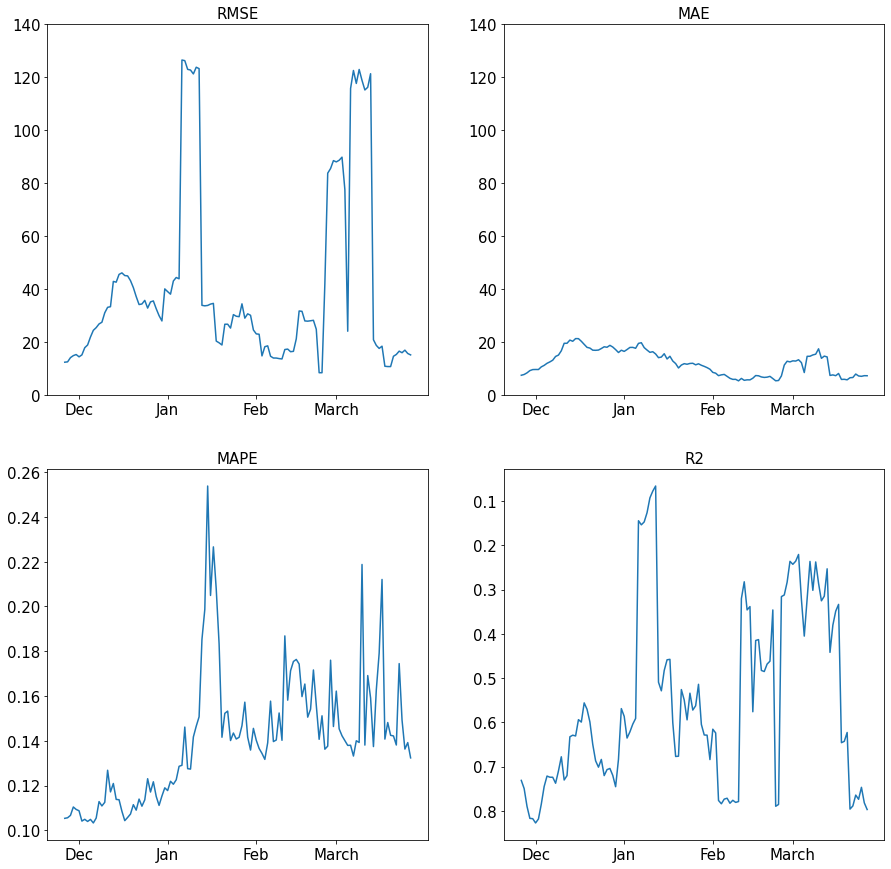

In [153]:
graph, ((plot1, plot2), (plot3, plot4)) = plt.subplots(2, 2)


plot1.plot(val_RMSE_list)
plot1.set_title('RMSE', size=15)
plot1.set_ylim([0,140])

plot2.plot(val_MAE_list)
plot2.set_title('MAE',size=15)
plot2.set_ylim([0,140])

plot3.plot(val_MAPE_list)
plot3.set_title('MAPE',size=15)


plot4.plot(val_R2_list)
plot4.set_title('R2',size=15)
plot4.invert_yaxis()


graph.set_figheight(15)
graph.set_figwidth(15)

for i in[plot1,plot2,plot3,plot4]:
    plt.sca(i)
    plt.xticks(day, month, size=15)
    plt.yticks(size=15)
    

